### Шаг 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
!pip install phik
import phik
import os
from phik.report import plot_correlation_matrix
from phik import report
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 679 kB 1.6 MB/s eta 0:00:01


In [2]:
bank = pd.read_csv('/datasets/bank_dataset.csv')

In [3]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [4]:
bank.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [5]:
bank = pd.concat([bank, pd.get_dummies(bank['City'], columns=['City'])], axis=1)
bank['Gender_numeric'] = bank['Gender'].map({'М': 0, 'Ж': 1})

In [6]:
bank.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn,Ростов Великий,Рыбинск,Ярославль,Gender_numeric
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,0,1,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,0,1,1
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1


In [7]:
bank.rename(columns={'Ростов Великий': 'rostov', 'Рыбинск': 'rybinsk',
                     'Ярославль': 'yaroslavl'}, inplace=True)

In [8]:
bank.rename(columns=str.lower, inplace=True)

In [9]:
bank.head()

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,rostov,rybinsk,yaroslavl,gender_numeric
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,0,0,1,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,0,1,0,1
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,0,0,1,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,0,0,1,1
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,0,1,0,1


In [10]:
# проверка на наличие явных дубликатов
bank.duplicated().sum()

0

In [11]:
# посмотрим количество пропусков в ДФ
bank_nan = bank.isna().sum()
bank_nan

userid                 0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
creditcard             0
loyalty                0
estimated_salary       0
churn                  0
rostov                 0
rybinsk                0
yaroslavl              0
gender_numeric         0
dtype: int64

очень много пропусков в строке баланс

In [12]:
bank['balance'].describe()

count      6383.000000
mean     119827.493793
std       30095.056462
min        3768.690000
25%      100181.975000
50%      119839.690000
75%      139512.290000
max      250898.090000
Name: balance, dtype: float64

очень странно, что минимальное значение не 0. как бывший сотрудник банка могу сказать, что такое невозможно.  
у многих людей есть счета без средств. думаю, что часть пропусков является нулевым значением. как собирались данные, нам не известно  
считаю важным проверить данные по балансу в разрезе других столбцов

In [13]:
bank = bank.rename(columns={'ростов': 'rostov', 'credit_card': 'creditcard', 'equity': 'objects', 'last_activity': 'loyalty'})

In [14]:
bank['balance_missing'] = bank['balance'].isna()

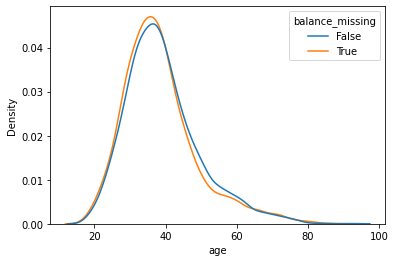

Разница средних:


rostov       -1.000000
rybinsk       0.655635
yaroslavl     0.643720
churn        -0.425920
products      0.287587
creditcard    0.024907
dtype: float64

In [15]:
sns.kdeplot(data=bank,x='age',hue='balance_missing',common_norm=False)
plt.show()

print('Разница средних:')
mean_miss = bank.groupby('balance_missing').mean().T
(mean_miss[True]/mean_miss[False] - 1)\
    .sort_values(key=abs,ascending=False).head(6)

Исходя из этих результатов корреляции, можно сделать вывод, что количество объектов в собственности, количество продуктов, город проживания и наличие кредитной карты могут быть факторами, влияющими на пустые значения. Заработная плата клиента также может играть роль в пропсуках.

In [16]:
# пропуски в столбце balance, у кого есть кредитная карта и среди активных клиентов
print("пропуски в столбце balance, у кого есть кредитная карта:", bank[bank['creditcard'] == 1]['balance'].isnull().sum())
print("пропуски в столбце balance, среди активных клиентов:",bank[bank['loyalty']==1]['balance_missing'].sum())

пропуски в столбце balance, у кого есть кредитная карта: 2592
пропуски в столбце balance, среди активных клиентов: 1873


не может быть, чтобы у активного клиента или клента с кредитной картой был пропуск в балансе.  

In [17]:
city_missbalance = bank[bank['balance'].isnull()].groupby('city')['balance'].count() / bank.groupby('city')['balance'].count()
city_missbalance

city
Ростов Великий    NaN
Рыбинск           0.0
Ярославль         0.0
Name: balance, dtype: float64

данный тип пропусков я бы отнёс к MNAR (Missing Not At Random / Отсутствует не случайно). Так как пропуски есть только в Ростове, может произошла ошибка при выгрузке данных из этого филиала. считаю правильным заменить пропуски на 0

In [18]:
mar_bank = bank.groupby(['city', 'churn', 'products', 'creditcard'])

def impute_balance(group):
    group['balance'] = group['balance'].fillna(group['balance'].mean())
    return group

bank = mar_bank.apply(impute_balance)
missing_balance =bank.isna().sum()
missing_balance

userid               0
score                0
city                 0
gender               0
age                  0
objects              0
balance             36
products             0
creditcard           0
loyalty              0
estimated_salary     0
churn                0
rostov               0
rybinsk              0
yaroslavl            0
gender_numeric       0
balance_missing      0
dtype: int64

осталось 36 пропусков, что является менее 1 процента от всех данных, считаю допустимым оставить их нетронутыми.

### Шаг 2. Исследовательский анализ данных

#### Портрет клиента

In [19]:
# демографические характеристики
gender_counts = bank['gender'].value_counts()
age_mean = round(bank['age'].mean(), 2)
city_counts = bank['city'].value_counts()
objects_mean = round(bank['objects'].mean(), 2)
# финансовые характеристики
balance_mean = round(bank['balance'].mean(), 2)
products_mean = round(bank['products'].mean(), 2)
creditcard_counts = bank['creditcard'].value_counts()
estimated_salary_mean = round(bank['estimated_salary'].mean(), 2)
loyalty_counts = bank['loyalty'].value_counts()
# поведенческие характеристики
score_mean = round(bank['score'].mean(), 2)
churn_counts = bank['churn'].value_counts()

print("демографические характеристики")
print(f"количество мужчин: {gender_counts['М']}")
print(f"количество женщин: {gender_counts['Ж']}")
print(f"средний возраст: {age_mean}")
print(f"количество клиентов из Ростов Великого: {city_counts['Ростов Великий']}")
print(f"количество клиентов из Рыбинска: {city_counts['Рыбинск']}")
print(f"количество клиентов из Ярославля: {city_counts['Ярославль']}")
print(f"среднее количество объектов в собственности: {objects_mean}")
print()
print("финансовое положение")
print(f"средний баланс на счете: {balance_mean}")
print(f"среднее количество продуктов: {products_mean}")
print(f"количество клиентов с кредитной картой: {creditcard_counts[1]}")
print(f"средняя заработная плата: {estimated_salary_mean}")
print(f"количество активных клиентов: {loyalty_counts[1]}")
print()
print("поведенческие характеристики")
print(f"средний кредитный рейтинг: {score_mean}")
print(f"количество ушедших клиентов: {churn_counts[1]}")

демографические характеристики
количество мужчин: 5457
количество женщин: 4543
средний возраст: 38.92
количество клиентов из Ростов Великого: 2509
количество клиентов из Рыбинска: 2477
количество клиентов из Ярославля: 5014
среднее количество объектов в собственности: 5.01

финансовое положение
средний баланс на счете: 119901.72
среднее количество продуктов: 1.53
количество клиентов с кредитной картой: 7055
средняя заработная плата: 100090.24
количество активных клиентов: 5151

поведенческие характеристики
средний кредитный рейтинг: 650.53
количество ушедших клиентов: 2037


In [20]:
bank.describe().round(2)

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,rostov,rybinsk,yaroslavl,gender_numeric
count,10000.00,10000.00,10000.00,10000.00,9964.00,10000.00,10000.00,10000.00,10000.00,10000.0,10000.00,10000.00,10000.0,10000.00
mean,15733676.57,650.53,38.92,5.01,119901.72,1.53,0.71,0.52,100090.24,0.2,0.25,0.25,0.5,0.45
std,71936.19,96.65,10.49,2.89,24172.63,0.58,0.46,0.50,57510.49,0.4,0.43,0.43,0.5,0.50
min,15608437.00,350.00,18.00,0.00,3768.69,1.00,0.00,0.00,11.58,0.0,0.00,0.00,0.0,0.00
25%,15671264.25,584.00,32.00,3.00,111373.94,1.00,0.00,0.00,51002.11,0.0,0.00,0.00,0.0,0.00
50%,15733474.00,652.00,37.00,5.00,119953.74,1.00,1.00,1.00,100193.92,0.0,0.00,0.00,1.0,0.00
75%,15795969.75,718.00,44.00,7.00,127863.26,2.00,1.00,1.00,149388.25,0.0,1.00,0.00,1.0,1.00
max,15858426.00,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0,1.00,1.00,1.0,1.00


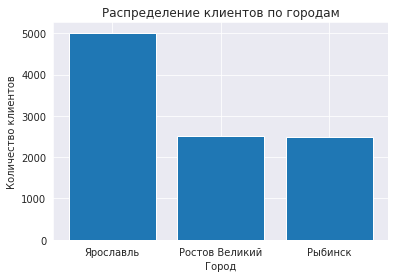

In [21]:
sns.set_style('darkgrid')
city_counts = bank['city'].value_counts()
plt.bar(city_counts.index, city_counts.values)
plt.xlabel('Город')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по городам')
plt.show()

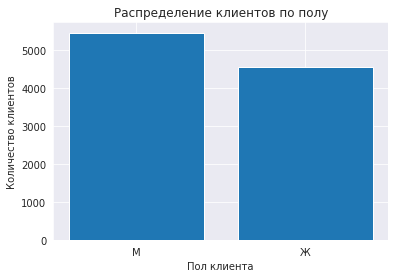

In [22]:
sns.set_style('darkgrid')
gender_counts = bank['gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values)
plt.xlabel('Пол клиента')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по полу')
plt.show()

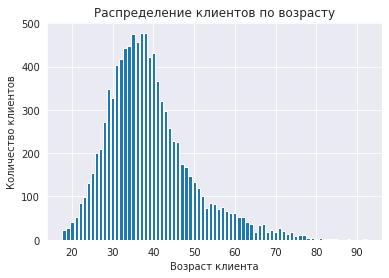

In [23]:
sns.set_style('darkgrid')
age_counts = bank['age'].value_counts()
plt.bar(age_counts.index, age_counts.values)
plt.xlabel('Возраст клиента')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по возрасту')
plt.show()

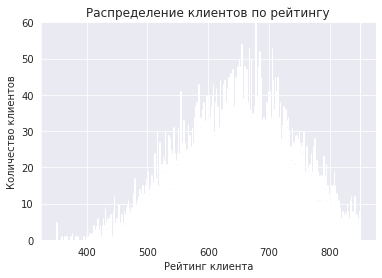

In [24]:
sns.set_style('darkgrid')
rating_counts = bank['score'].value_counts()
plt.bar(rating_counts.index, rating_counts.values)
plt.xlabel('Рейтинг клиента')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по рейтингу')
plt.ylim(0, 60)
plt.show()

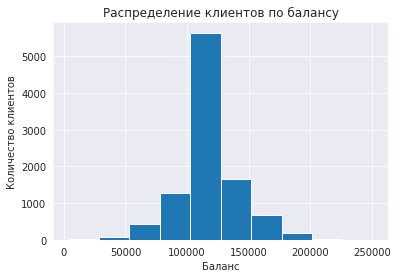

In [25]:
sns.set_style('darkgrid')
plt.hist(bank['balance'], bins=10)
plt.xlabel('Баланс')
plt.ylabel('Количество клиентов')
plt.title('Распределение клиентов по балансу')
plt.show()

Портрет клиента выглядит следующим образом:  

-ему примерно 39 лет  
-его доход около 100000 р  
-у него хороший рейтинг, около 650 баллов  
-чаще это мужчина  
-и с большей вероятностью он из ярославля

#### Портрет неотточного клиента:

In [26]:
# демографические характеристики
nochurn_gender_counts = bank[bank['churn'] == 0]['gender'].value_counts()
nochurn_age_mean = round(bank[bank['churn'] == 0]['age'].mean(), 2)
nochurn_city_counts = bank[bank['churn'] ==0]['city'].value_counts()
nochurn_objects_mean = round(bank[bank['churn'] == 0]['objects'].mean(), 2)

# финансовое положение
nochurn_balance_mean = round(bank[bank['churn'] == 0]['balance'].mean(), 2)
nochurn_products_mean = round(bank[bank['churn'] == 0]['products'].mean(), 2)
nochurn_creditcard_counts = bank[bank['churn'] == 0]['creditcard'].value_counts()
nochurn_estimated_salary_mean = round(bank[bank['churn'] == 1]['estimated_salary'].mean(), 2)
nochurn_loyalty_counts = bank[bank['churn'] == 0]['loyalty'].value_counts()

# поведенческие характеристики
nochurn_score_mean = round(bank[bank['churn'] == 0]['score'].mean(), 2)

# вывод портрета отточного клиента
print("Информация о неотточном клиенте:")
print("демографические характеристики:")
print(f"количество мужчин: {nochurn_gender_counts['М']}")
print(f"количество женщин: {nochurn_gender_counts['Ж']}")
print(f"средний возраст: {nochurn_age_mean}")
print(f"количество клиентов из Ростова Великого: {nochurn_city_counts['Ростов Великий']}")
print(f"количество клиентов из Рыбинска: {nochurn_city_counts['Рыбинск']}")
print(f"количество клиентов из Ярославля: {nochurn_city_counts['Ярославль']}")
print(f"среднее количество объектов в собственности: {nochurn_objects_mean}")
print()
print("финансовое положение:")
print(f"средний баланс на счете: {nochurn_balance_mean}")
print(f"среднее количество продуктов: {nochurn_products_mean}")
print(f"количество клиентов с кредитной картой: {nochurn_creditcard_counts[1]}")
print(f"средняя заработная плата: {nochurn_estimated_salary_mean}")
print(f"количество активных клиентов: {nochurn_loyalty_counts[1]}")
print()
print(f"средний кредитный рейтинг: {nochurn_score_mean}")

Информация о неотточном клиенте:
демографические характеристики:
количество мужчин: 4559
количество женщин: 3404
средний возраст: 37.41
количество клиентов из Ростова Великого: 1695
количество клиентов из Рыбинска: 2064
количество клиентов из Ярославля: 4204
среднее количество объектов в собственности: 5.03

финансовое положение:
средний баланс на счете: 119680.53
среднее количество продуктов: 1.54
количество клиентов с кредитной картой: 5631
средняя заработная плата: 101465.68
количество активных клиентов: 4416

средний кредитный рейтинг: 651.85


Портрет неотточного клиента:
- скорее всего, это мужчина
- скорее всего он из Ярославля
- возраст около 37-38 лет
- на его балансе около 73000р
- у него 1-2 продукта 

#### Портрет отточного клиента выглядит следующим образом:

In [36]:
# демографические характеристики
churn_gender_counts = bank[bank['churn'] == 1]['gender'].value_counts()
churn_age_mean = round(bank[bank['churn'] == 1]['age'].mean(), 2)
churn_city_counts = bank[bank['churn'] == 1]['city'].value_counts()
churn_objects_mean = round(bank[bank['churn'] == 1]['objects'].mean(), 2)

# финансовое положение
churn_balance_mean = round(bank[bank['churn'] == 1]['balance'].mean(), 2)
churn_products_mean = round(bank[bank['churn'] == 1]['products'].mean(), 2)
churn_creditcard_counts = bank[bank['churn'] == 1]['creditcard'].value_counts()
churn_estimated_salary_mean = round(bank[bank['churn'] == 1]['estimated_salary'].mean(), 2)
churn_loyalty_counts = bank[bank['churn'] == 1]['loyalty'].value_counts()

# поведенческие характеристики
churn_score_mean = round(bank[bank['churn'] == 1]['score'].mean(), 2)

# вывод портрета отточного клиента
print("Информация об отточном клиенте:")
print("демографические характеристики:")
print(f"количество мужчин: {churn_gender_counts['М']}")
print(f"количество женщин: {churn_gender_counts['Ж']}")
print(f"средний возраст: {churn_age_mean}")
print(f"количество клиентов из Ростова Великого: {churn_city_counts['Ростов Великий']}")
print(f"количество клиентов из Рыбинска: {churn_city_counts['Рыбинск']}")
print(f"количество клиентов из Ярославля: {churn_city_counts['Ярославль']}")
print(f"среднее количество объектов в собственности: {churn_objects_mean}")
print()
print("финансовое положение:")
print(f"средний баланс на счете: {churn_balance_mean}")
print(f"среднее количество продуктов: {churn_products_mean}")
print(f"количество клиентов с кредитной картой: {churn_creditcard_counts[1]}")
print(f"средняя заработная плата: {churn_estimated_salary_mean}")
print(f"количество активных клиентов: {churn_loyalty_counts[1]}")
print()
print(f"средний кредитный рейтинг: {churn_score_mean}")

Информация об отточном клиенте:
демографические характеристики:
количество мужчин: 898
количество женщин: 1139
средний возраст: 44.84
количество клиентов из Ростова Великого: 814
количество клиентов из Рыбинска: 413
количество клиентов из Ярославля: 810
среднее количество объектов в собственности: 4.93

финансовое положение:
средний баланс на счете: 120762.47
среднее количество продуктов: 1.48
количество клиентов с кредитной картой: 1424
средняя заработная плата: 101465.68
количество активных клиентов: 735

средний кредитный рейтинг: 645.35


Портрет отточного клиента выглядит следующим образом:  
-скорее всего это женищина  
-возраст в промежутке между 44 и 45  
-скорее всего она из Ростова или Ярославля
-баланс около 91000р  
-зредняя зп 101000р


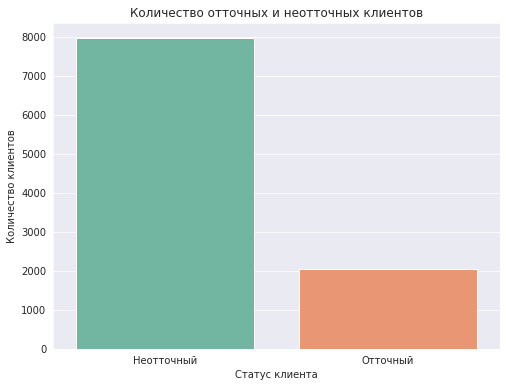

In [37]:
churn_counts = bank['churn'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='Set2')
plt.xlabel('Статус клиента')
plt.ylabel('Количество клиентов')
plt.title('Количество отточных и неотточных клиентов')
plt.xticks([0, 1], ['Неотточный', 'Отточный'])
plt.show()

In [38]:
diff_percent_balance = ((churn_balance_mean - nochurn_balance_mean) / balance_mean) * 100
print(f"Баланс отточного клиента больше обычного на {diff_percent_balance:.2f}%")

diff_percent_age = ((churn_age_mean - nochurn_age_mean) / age_mean) * 100
print(f"Средний возраст отточного клиента больше среднего возраста обычного клиента на {diff_percent_age:.2f}%")

diff_percent_score = ((nochurn_score_mean - churn_score_mean) / churn_score_mean) * 100
print(f"Средний рейтинг обычного клиента больше среднего рейтинга отточного клиента на {diff_percent_score:.2f}%")

Баланс отточного клиента больше обычного на 0.90%
Средний возраст отточного клиента больше среднего возраста обычного клиента на 19.09%
Средний рейтинг обычного клиента больше среднего рейтинга отточного клиента на 1.01%


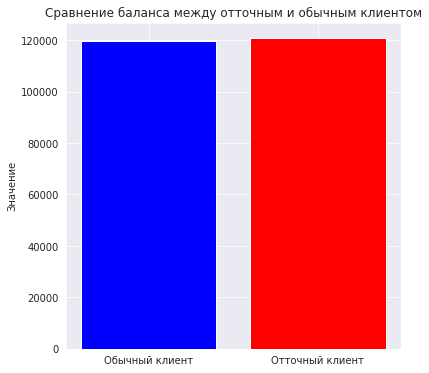

In [39]:
labels = ['Обычный клиент', 'Отточный клиент']
values = [nochurn_balance_mean, churn_balance_mean]

plt.figure(figsize=(6, 6))
plt.bar(labels, values, color=['blue', 'red'])
plt.ylabel('Значение')
plt.title('Сравнение баланса между отточным и обычным клиентом')

plt.show()

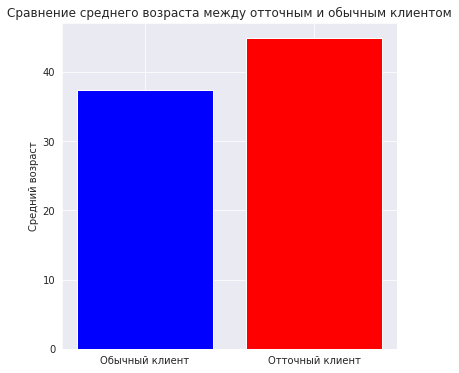

In [40]:
labels = ['Обычный клиент', 'Отточный клиент']
values = [nochurn_age_mean, churn_age_mean]

plt.figure(figsize=(6, 6))
plt.bar(labels, values, color=['blue', 'red'])
plt.ylabel('Средний возраст')
plt.title('Сравнение среднего возраста между отточным и обычным клиентом')

plt.show()

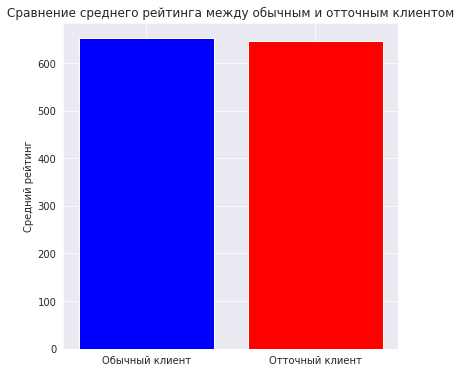

In [41]:
labels = ['Обычный клиент', 'Отточный клиент']
values = [nochurn_score_mean, churn_score_mean]
plt.figure(figsize=(6, 6))
plt.bar(labels, values, color=['blue', 'red'])
plt.ylabel('Средний рейтинг')
plt.title('Сравнение среднего рейтинга между обычным и отточным клиентом')
plt.show()

In [42]:
no_churn_bank = bank[bank['churn'] != 1]
no_churn_bank.describe()

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn,rostov,rybinsk,yaroslavl,gender_numeric
count,7.963000e+03,7963.000000,7963.000000,7963.000000,7927.000000,7963.000000,7963.000000,7963.000000,7963.000000,7963.0,7963.000000,7963.000000,7963.000000,7963.000000
mean,1.573390e+07,651.853196,37.408389,5.033279,119680.528629,1.544267,0.707146,0.554565,99738.391772,0.0,0.212859,0.259199,0.527942,0.427477
std,7.174423e+04,95.653837,10.125363,2.880658,23474.929131,0.509536,0.455101,0.497045,57405.586966,0.0,0.409355,0.438222,0.499250,0.494744
min,1.560844e+07,405.000000,18.000000,0.000000,14262.800000,1.000000,0.000000,0.000000,90.070000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.567155e+07,585.000000,31.000000,3.000000,112532.610000,1.000000,0.000000,0.000000,50783.490000,0.0,0.000000,0.000000,0.000000,0.000000
50%,1.573428e+07,653.000000,36.000000,5.000000,119655.241370,2.000000,1.000000,1.000000,99645.040000,0.0,0.000000,0.000000,1.000000,0.000000
75%,1.579609e+07,718.000000,41.000000,7.000000,126529.355000,2.000000,1.000000,1.000000,148609.955000,0.0,0.000000,1.000000,1.000000,1.000000
max,1.585843e+07,850.000000,92.000000,10.000000,221532.800000,3.000000,1.000000,1.000000,199992.480000,0.0,1.000000,1.000000,1.000000,1.000000


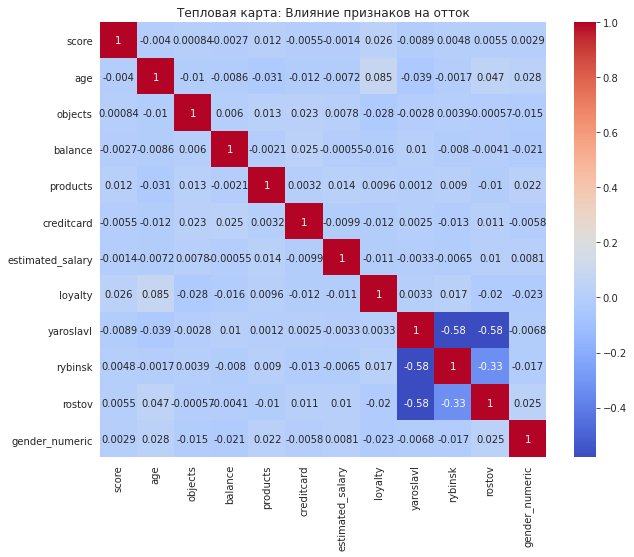

In [43]:
features = ['score', 'age', 'objects', 'balance', 'products', 'creditcard', 'estimated_salary', 'loyalty', 'yaroslavl', 'rybinsk', 'rostov', 'gender_numeric' ]
correlation_matrix = bank[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта: Влияние признаков на отток')
plt.show()

interval columns not set, guessing: ['userid', 'score', 'age', 'objects', 'balance', 'products', 'creditcard', 'loyalty', 'estimated_salary', 'churn', 'rostov', 'rybinsk', 'yaroslavl', 'gender_numeric']


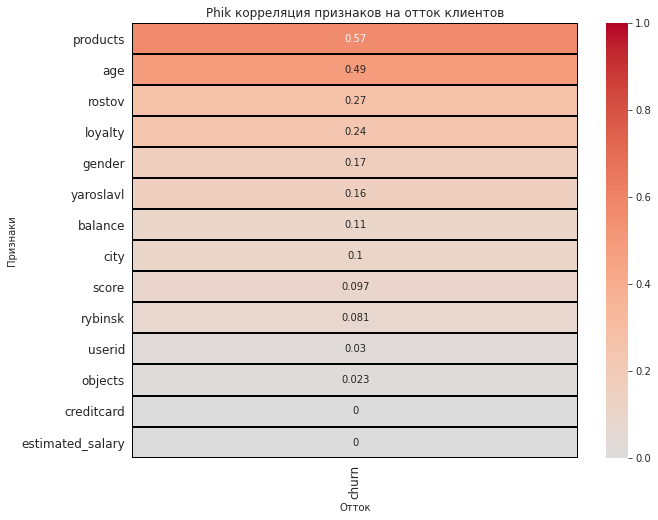

In [44]:
df_phik = bank.phik_matrix().drop(['churn', 'balance_missing', 'gender_numeric']).sort_values('churn', ascending=False)
plt.figure(figsize=(10, 8))
sns.heatmap(df_phik[['churn']], annot=True, vmin=0, vmax=1, center=0, cmap='coolwarm', linewidths=1, linecolor='black')
plt.title('Phik корреляция признаков на отток клиентов')
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.ylabel('Признаки')
plt.xlabel('Отток')
plt.show()

самая высокая корреляция с продуктами (0.57), затем с возрастом (0.49), с городом Ростовом (0.27), активностью (0.24), количеством денежных средств (0.18), пол (0.17) и город Ярославль (0.16)

### Описание данных, коррелирующих с оттоком/неоттоком

#### Количество продуктов, которыми пользуется клиент

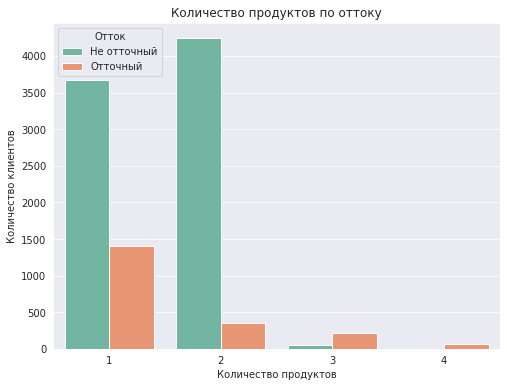

In [45]:
plt.figure(figsize=(8, 6))
sns.countplot(data=bank, x='products', hue='churn', palette='Set2')
plt.xlabel('Количество продуктов')
plt.ylabel('Количество клиентов')
plt.title('Количество продуктов по оттоку')
plt.legend(title='Отток', labels=['Не отточный', 'Отточный'])
plt.show()

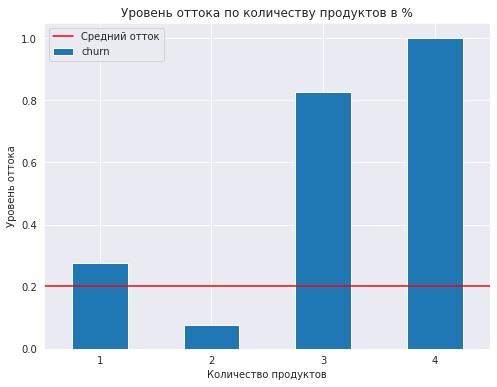

In [46]:
plt.figure(figsize=(8, 6))
churn_rates = bank.groupby('products')['churn'].mean()
churn_rates.plot(kind='bar')
plt.axhline(y=bank['churn'].mean(), color='red', linestyle='-', label='Средний отток')
plt.xlabel('Количество продуктов')
plt.ylabel('Уровень оттока')
plt.title('Уровень оттока по количеству продуктов в %')
plt.legend()
plt.xticks(rotation=360) 
plt.show()

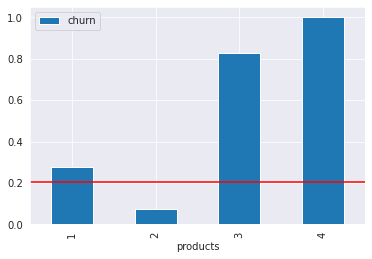

In [47]:
### КОД РЕВЬЮЕРА 2
bank.groupby('products').agg({'churn':'mean'}).plot.bar().axhline(bank.churn.mean(),c='red');

#### Распределение  отточных и неотточных клиентов по возрасту

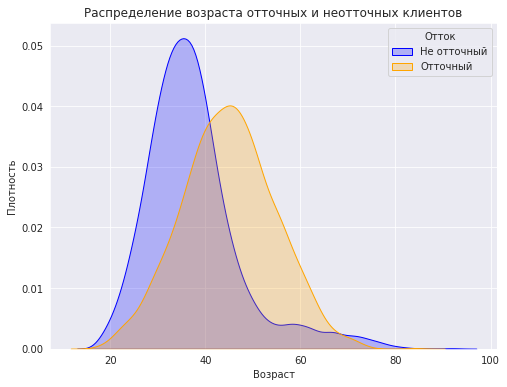

In [48]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=bank[bank['churn'] == 0], x='age', label='Не отточный', shade=True, color='blue')
sns.kdeplot(data=bank[bank['churn'] == 1], x='age', label='Отточный', shade=True, color='orange')
plt.xlabel('Возраст')
plt.ylabel('Плотность')
plt.title('Распределение возраста отточных и неотточных клиентов')
plt.legend(title='Отток')
plt.show()

#### Распределение  отточных и неотточных клиентов в городе Ростов Великий

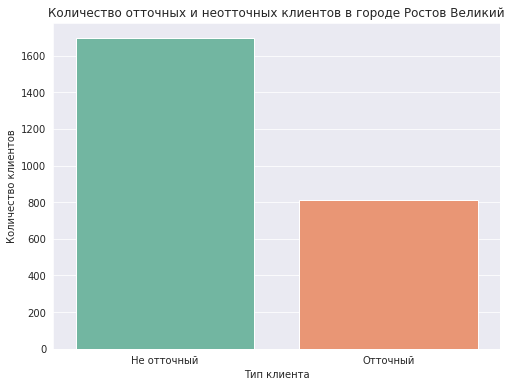

In [49]:
plt.figure(figsize=(8, 6))
sns.countplot(data=bank[bank['city'] == 'Ростов Великий'], x='churn', palette='Set2')
plt.xlabel('Тип клиента')
plt.ylabel('Количество клиентов')
plt.title('Количество отточных и неотточных клиентов в городе Ростов Великий')
plt.xticks([0, 1], ['Не отточный', 'Отточный'])
plt.show()

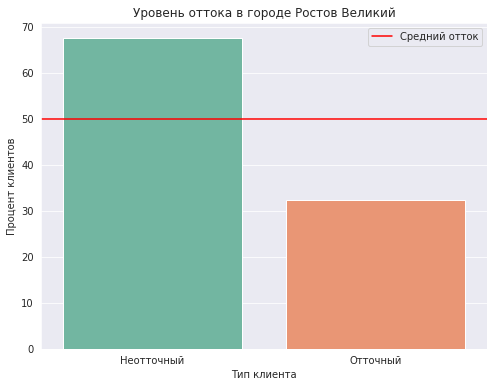

In [50]:
plt.figure(figsize=(8, 6))
churn_counts = bank[bank['city'] == 'Ростов Великий']['churn'].value_counts()
churn_percent = churn_counts / churn_counts.sum() * 100

sns.barplot(x=churn_counts.index, y=churn_percent, palette='Set2')
plt.xlabel('Тип клиента')
plt.ylabel('Процент клиентов')
plt.title('Уровень оттока в городе Ростов Великий')
plt.xticks([0, 1], ['Неотточный', 'Отточный'])
plt.axhline(y=churn_percent.mean(), color='red', linestyle='-', label='Средний отток')
plt.legend()
plt.show()

#### Распределение лояльности отточных и неотточных клиентов

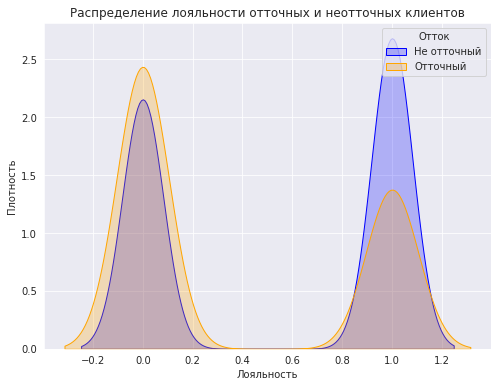

In [51]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=bank[bank['churn'] == 0], x='loyalty', label='Не отточный', shade=True, color='blue')
sns.kdeplot(data=bank[bank['churn'] == 1], x='loyalty', label='Отточный', shade=True, color='orange')
plt.xlabel('Лояльность')
plt.ylabel('Плотность')
plt.title('Распределение лояльности отточных и неотточных клиентов')
plt.legend(title='Отток')
plt.show()

#### Распределение баланса отточных и неотточных клиентов

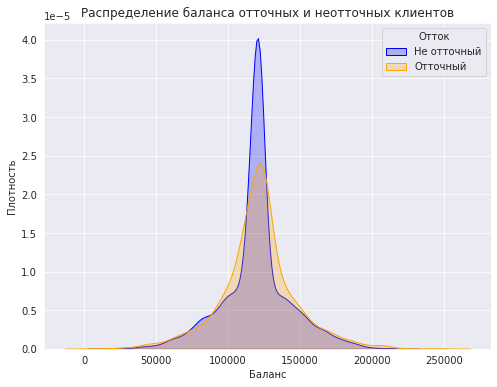

In [52]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=bank[bank['churn'] == 0], x='balance', label='Не отточный', shade=True, color='blue')
sns.kdeplot(data=bank[bank['churn'] == 1], x='balance', label='Отточный', shade=True, color='orange')
plt.xlabel('Баланс')
plt.ylabel('Плотность')
plt.title('Распределение баланса отточных и неотточных клиентов')
plt.legend(title='Отток')
plt.show()

#### Распределение доходов отточных и неотточных клиентов

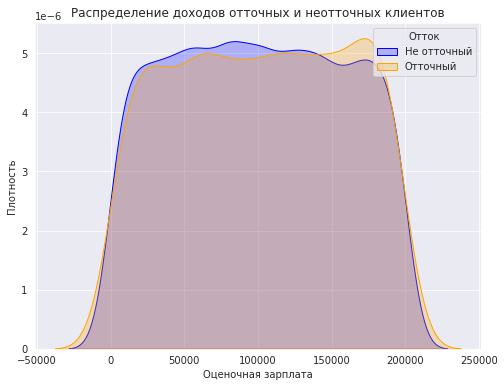

In [54]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=bank[bank['churn'] == 0], x='estimated_salary', label='Не отточный', shade=True, color='blue')
sns.kdeplot(data=bank[bank['churn'] == 1], x='estimated_salary', label='Отточный', shade=True, color='orange')
plt.xlabel('Оценочная зарплата')
plt.ylabel('Плотность')
plt.title('Распределение доходов отточных и неотточных клиентов')
plt.legend(title='Отток')
plt.show()

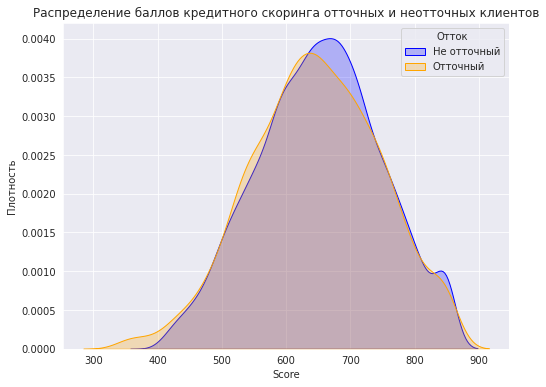

In [55]:
plt.figure(figsize=(8, 6))
sns.kdeplot(data=bank[bank['churn'] == 0], x='score', label='Не отточный', shade=True, color='blue')
sns.kdeplot(data=bank[bank['churn'] == 1], x='score', label='Отточный', shade=True, color='orange')
plt.xlabel('Score')
plt.ylabel('Плотность')
plt.title('Распределение баллов кредитного скоринга отточных и неотточных клиентов')
plt.legend(title='Отток')
plt.show()

### Проверка гипотез

#### Формулировка первой гипотезы:  
Нулевая гипотеза: разницы между доходами отточных и неотточных клиентов нет  
Альтернативная гипотеза: разница между доходами отточных и неотточных клиентов есть

##### проверка  t-критерием 

In [56]:
churned = bank[bank['churn'] == 1]['estimated_salary']
not_churned = bank[bank['churn'] == 0]['estimated_salary']

t, p = ttest_ind(churned, not_churned)
print('t-статистика:', t)
print('p-значение:', p)

alpha = 0.05
if p < alpha:
    print('Отвергаем нулевую гипотезу: разница между доходами отточных и неотточных клиентов есть')
else:
    print('Не удалось отвергнуть нулевую гипотезу: разницы между доходами отточных и неотточных клиентов нет')


t-статистика: 1.209653638019264
p-значение: 0.22644042802223352
Не удалось отвергнуть нулевую гипотезу: разницы между доходами отточных и неотточных клиентов нет


##### проверка u-критерием 

In [57]:
churned = bank[bank['churn'] == 1]['estimated_salary']
not_churned = bank[bank['churn'] == 0]['estimated_salary']

u, p = mannwhitneyu(churned, not_churned, alternative='two-sided')
print('статистика U:', u)
print('p-значение:', p)

alpha = 0.05
if p < alpha:
    print('Отвергаем нулевую гипотезу: разница между доходами отточных и неотточных клиентов есть')
else:
    print('Не удалось отвергнуть нулевую гипотезу: разницы между доходами отточных и неотточных клиентов нет')

статистика U: 8250768.0
p-значение: 0.22705150930153783
Не удалось отвергнуть нулевую гипотезу: разницы между доходами отточных и неотточных клиентов нет


вообще, данные критерии теоретически могут давать разные результаты, т.к. критерий стьюдента предполагает нормальное распределение данных, а U-критерий Манна-Уитни не делает такого предположения  
Если данные не соответствуют предположению о нормальности, результаты двух критериев могут отличаться

обе гипотезы (как и графики ранее) подтверждают, что различий между доходами отточных и неотточных клентов нет.

#### Формулировка второй гипотезы:  
считаю важным проверить, есть ли взаимосвязь между возрастом или оттоком, так как на графике наблюдается отток в районе 45 лет, но непонятно, закономерность это или нет

Нулевая гипотеза: разницы между возрастом  отточных и неотточных клиентов нет  
Альтернативная гипотеза: разница между возастом продуктов отточных и неотточных клиентов есть


In [58]:
age_churned = bank[bank['churn'] == 1]['age']
age_not_churned = bank[bank['churn'] == 0]['age']
t_stat, p_value = ttest_ind(age_churned, age_not_churned)
print("t-статистика:", t_stat)
print("p-значение:", p_value)

alpha = 0.05  
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. Существует статистически значимая разница в возрасте между отточными и неотточными клиентами.")
else:
    print("Не отвергаем нулевую гипотезу. Нет статистически значимой разницы в возрасте между отточными и неотточными клиентами.")


t-статистика: 29.76681499437077
p-значение: 1.2399313093427738e-186
Отвергаем нулевую гипотезу. Существует статистически значимая разница в возрасте между отточными и неотточными клиентами.


### Сегментизация

Мы выделили основные криетрии неотточногго клиента:   
- пол (скорее всего, это мужчина)
- местоположение (скорее всего он из Ярославля)
- возраст около 35-40 лет
- на его балансе от 110000 до 130000
- у него 2 продукта
- и он является лояльным клиентом

In [59]:
bank_gender = bank.query("gender == 'М'")
bank_city = bank.query("city == 'Ярославль'")
bank_age = bank.query("age >= 35 and age <= 40")
bank_balance = bank.query("balance >= 110000 and balance <= 130000")
bank_products = bank.query("products == 2")
bank_loyalty = bank.query("loyalty == 1")

criteria = ['пол', 'Ярославль', 'возраст', 'баланс', '2 продукта', 'лояльность']
values = [bank_gender, bank_city, bank_age, bank_balance, bank_products, bank_loyalty]

for criterion, value in zip(criteria, values):
    total_clients = value.shape[0]
    churned_clients = value[value['churn'] == 1].shape[0]
    churn_percentage = (churned_clients / total_clients) * 100
    
    print(f"{criterion}:")
    print(f"Количество неотточных клиентов: {churned_clients}")
    print(f"Процент неотточных клиентов: {churn_percentage:.2f}%")
    print("")


пол:
Количество неотточных клиентов: 898
Процент неотточных клиентов: 16.46%

Ярославль:
Количество неотточных клиентов: 810
Процент неотточных клиентов: 16.15%

возраст:
Количество неотточных клиентов: 396
Процент неотточных клиентов: 14.45%

баланс:
Количество неотточных клиентов: 946
Процент неотточных клиентов: 17.88%

2 продукта:
Количество неотточных клиентов: 348
Процент неотточных клиентов: 7.58%

лояльность:
Количество неотточных клиентов: 735
Процент неотточных клиентов: 14.27%



процент неоттока в каждой группе 
пол+ярославль, возраст+лояльность, 1-2 продукта+баланс

In [60]:
# Пол + Ярославль
segment1 = bank[(bank['gender'] == 'М') & (bank['city'] == 'Ярославль')]

# Возраст + Лояльность
segment2 = bank[(bank['age'] >= 35) & (bank['age'] <= 40) & (bank['loyalty'] == 1)]

# 2 продукта + Баланс
segment3 = bank[(bank['products'].isin([2])) & (bank['balance'] >= 110000) & (bank['balance'] <= 130000)]

Пол + Ярославль:
Процент неотточных клиентов: 12.71%



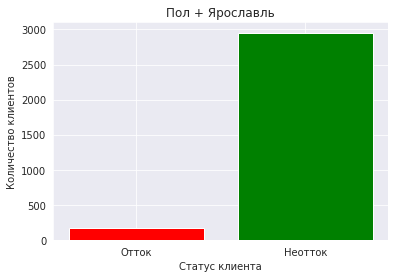

Возраст + Лояльность:
Процент неотточных клиентов: 10.90%



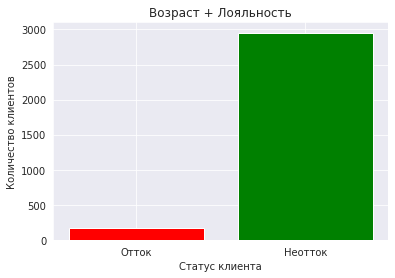

2 продукта + Баланс:
Процент неотточных клиентов: 5.53%



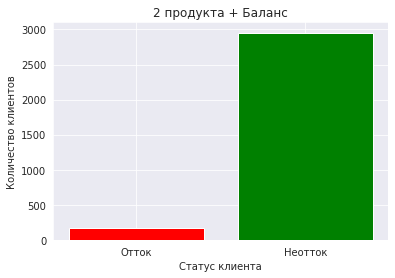

Пол + Ярославль:
Процент неотточных клиентов: 12.71%

Возраст + Лояльность:
Процент неотточных клиентов: 10.90%

2 продукта + Баланс:
Процент неотточных клиентов: 5.53%



In [61]:
segments = {
    'Пол + Ярославль': segment1,
    'Возраст + Лояльность': segment2,
    '2 продукта + Баланс': segment3
}

for segment, data in segments.items():
    churned_clients = data[data['churn'] == 1]
    not_churned_clients = data[data['churn'] == 0]

    churned_count = churned_clients.shape[0]
    not_churned_count = not_churned_clients.shape[0]

    labels = ['Отток', 'Неотток']
    values = [churned_count, not_churned_count]
    colors = ['red', 'green']
фsegments = {
    'Пол + Ярославль': segment1,
    'Возраст + Лояльность': segment2,
    '2 продукта + Баланс': segment3
}

for segment, data in segments.items():
    churned_clients = data[data['churn'] == 1]
    not_churned_clients = data[data['churn'] == 0]

    churned_count = churned_clients.shape[0]
    not_churned_count = not_churned_clients.shape[0]
    total_clients = churned_count + not_churned_count

    churn_percentage = (not_churned_count / total_clients) * 100
    not_churned_percentage = 100 - churn_percentage

    print(f"{segment}:")
    print(f"Процент неотточных клиентов: {not_churned_percentage:.2f}%")
    print("")

    plt.bar(labels, values, color=colors)
    plt.title(segment)
    plt.xlabel('Статус клиента')
    plt.ylabel('Количество клиентов')
    plt.show()
    
for segment, data in segments.items():
    churned_clients = data[data['churn'] == 1]
    not_churned_clients = data[data['churn'] == 0]

    churned_count = churned_clients.shape[0]
    not_churned_count = not_churned_clients.shape[0]
    total_clients = churned_count + not_churned_count

    churn_percentage = (not_churned_count / total_clients) * 100
    not_churned_percentage = 100 - churn_percentage

    print(f"{segment}:")
    print(f"Процент неотточных клиентов: {not_churned_percentage:.2f}%")
    print("")

видим, что самый эффективный сегмент - 3 (с 1-2 продуктами и балансом от 110000 до 130000)

###  Общие выводы

Были сформиорваны портреты отточного клиента:  
-скорее всего это женищина  
-возраст в промежутке между 44 и 45  
-скорее всего она из Ростова или Ярославля -баланс около 91000р  
-средняя зп 101000р

и неотточного клиента:  
-скорее всего, это мужчина  
-скорее всего он из Ярославля  
-возраст около 37-38 лет  
-на его балансе около 73000р  
-у него 2 продукта

проверены две гипотезы:

1. средний доход отточных и неотточных клиентов равен
2. существует статистически значимая разница в возрасте между отточными и неотточными клиентами.

Рекомендации отделу маркетинга по привлечению неотточных клиентов:  
- Провести таргетированную рекламную кампанию, ориентированную на клиентов в городах, наша ЦА это клиенты 30-40 лет.  
- С учётом того, что самые лояльные - клиенты с 2 продуктами, клиентам, которые просто открывают у нас счёт, нужно предлагать открыть дополнительный продукт (вклад, НСЖ/ИСЖ)
- С учётом того, что самые лояльные - люди с балансом 110000 до 130000, предлагать людям свои свободные сбережения хранить в нашем банке, создавать выгодные условия для обычного счёта